# Building ladfills

## Explaining the model

* (1) - Objective : minimize the product of distance and waste amount (minimize the total distance/cost) of transporting all the quantity from centers to landfills
* (2) - For each center i, the amount leaving from i is equal to the quantity generated in center i
* (3) - For each landfill j, the amount coming to landfill j (from all centers i) is 0 if the landfill is not built, and unconstrained otherwise
* (4) - The maximum number of built landfills is 5
* (5) - Non-negativity constraints for the waste amount (we can only transport positive amounts)
* (6) - z is a binary variable for each landfill

We assume that it is feasible to travel in a eucledian distance between any center and any landfill. We are not taking the time of travel or traffic into account. We are also not expressing preferences for the location of landfills (for example some area may be more resiential). 

## Julia Implementation

In [8]:
using JuMP, Gurobi, CSV, DataFrames, PyPlot;

In [249]:
centers = CSV.read("centers.csv", header = false)
centers2 = CSV.read("centers2.csv", header = false)
landfills = CSV.read("landfills.csv", header = false)
landfills2 = CSV.read("landfills2.csv", header = false)
stations = CSV.read("stations.csv", header = false)
stations2 = CSV.read("stations2.csv", header = false)
quantity = CSV.read("q.csv", header = false)
quantity2 = CSV.read("q2.csv", header = false);

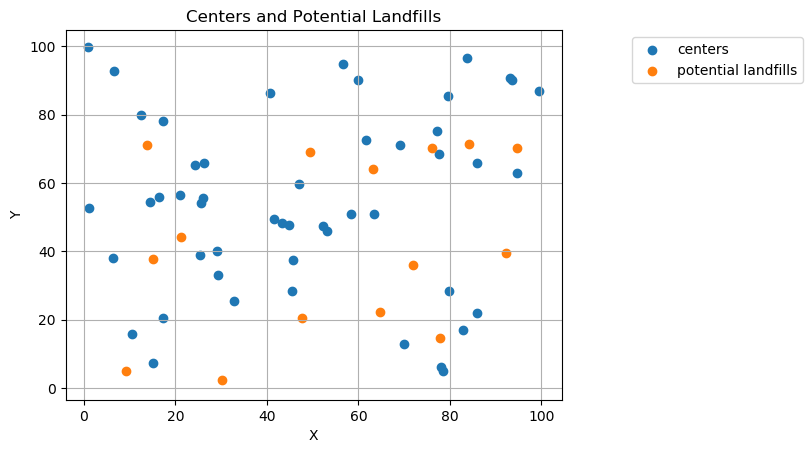

PyObject <matplotlib.legend.Legend object at 0x13f106f28>

In [347]:
scatter(centers[!,1],centers[!,2], label="centers")
scatter(landfills[!,1],landfills[!,2], label="potential landfills")
PyPlot.title("Centers and Potential Landfills")
xlabel("X")
ylabel("Y")
grid("on")
PyPlot.legend(bbox_to_anchor=(1.5,1))

In [273]:
function calculateDistance(start, ending) 
    m = size(start,1)
    n = size(ending,1)
    d = ones(m,n)
    
    for i=1:m
        for j=1:n
            d[i,j] = sqrt((start[i,1] - ending[j,1])^2 + (start[i,2] - ending[j,2])^2)
        end
    end
    return d
end

calculateDistance (generic function with 1 method)

In [254]:
d = calculateDistance(centers, landfills);

In [255]:
q = convert(Matrix,quantity);

In [274]:
function buildLandfills(d, q, a) 
    m, n = size(d)
    M = 1000000
    
    model = Model(solver = GurobiSolver(MIPGap=0.0001, OutputFlag=0))
    
    @variable(model, x[1:m,1:n] >= 0)
    @variable(model, z[1:n] >= 0, Bin)
    
    @objective(model, Min, sum(d[i,j] * x[i,j] for i in 1:m, j in 1:n));
    
    @constraint(model, [i=1:m], sum(x[i,j] for j=1:n) == q[i])  
    @constraint(model, [i=1:m, j=1:n], x[i,j] <= M * z[j]) 
    @constraint(model, sum(z[j] for j=1:n) <= a) 
    
    status = solve(model)
    
    x_solved = getvalue(x)
    z_solved = getvalue(z)
    distance = getobjectivevalue(model)
    
    return distance, x_solved, z_solved
end

buildLandfills (generic function with 2 methods)

In [275]:
distance, x, z = buildLandfills(d, q, 5) 

Academic license - for non-commercial use only


(840487.5240012797, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 774.29 0.0; 0.0 0.0 … 0.0 0.0], [-0.0, 0.0, 1.0, 1.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, 0.0, 0.0, 1.0, 1.0, -0.0])

Which landfills did we build:

In [276]:
l = convert(Matrix,landfills)
built_l = l .* z;
built_l_indeces = findall(x -> x>=1,built_l[:,1])

5-element Array{Int64,1}:
  3
  4
  7
 13
 14

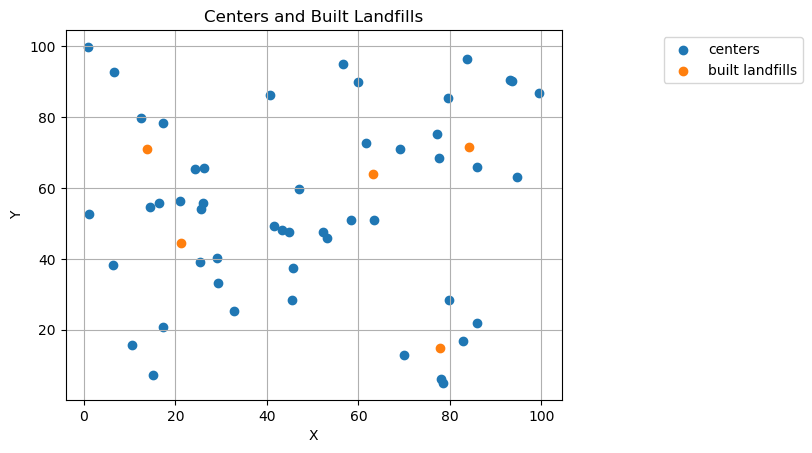

PyObject <matplotlib.legend.Legend object at 0x13e0735c0>

In [277]:
scatter(centers[!,1],centers[!,2], label="centers")
scatter(built_l[built_l_indeces,1],built_l[built_l_indeces,2], label="built landfills")
PyPlot.title("Centers and Built Landfills")
xlabel("X")
ylabel("Y")
grid("on")
PyPlot.legend(bbox_to_anchor=(1.5,1))

The total distance travelled by the waste is **840,488 ton miles.**

## Increasing landfills

In [354]:
for a=5:10
    distance1, x1, z1 = buildLandfills(d, q, a)
    built_l1 = l .* z1
    built_l1_indeces = findall(x -> x>=1,built_l1[:,1])
    println("Number of landfills: ", a)
    println("Total distance travelled ", distance1)
    println("Landfills build ", built_l1_indeces)
end

Academic license - for non-commercial use only
Number of landfills: 5
Total distance travelled 840487.5240012797
Landfills build [3, 4, 7, 13, 14]
Academic license - for non-commercial use only
Number of landfills: 6
Total distance travelled 784973.1017063985
Landfills build [3, 4, 7, 11, 13, 14]
Academic license - for non-commercial use only
Number of landfills: 7
Total distance travelled 751731.74144438
Landfills build [3, 4, 6, 7, 11, 13, 14]
Academic license - for non-commercial use only
Number of landfills: 8
Total distance travelled 723810.9577610842
Landfills build [3, 4, 5, 6, 7, 11, 13, 14]
Academic license - for non-commercial use only
Number of landfills: 9
Total distance travelled 707215.1395992909
Landfills build [2, 3, 4, 5, 6, 7, 11, 14, 15]
Academic license - for non-commercial use only
Number of landfills: 10
Total distance travelled 699121.1277070486
Landfills build [2, 3, 4, 5, 6, 7, 11, 12, 14, 15]


We build first 5, then 6, 7, .. 10 landfills. Each time the total distance, hence costs decreases, as the landfills are positioned closer to the centers. 

# Building ladfills and transfer stations
## Explaining the model

We explain what is different from the model in a
* (1) - Objective : minimize the transport cost from centers to landfills (distance x amount x cost of uncompacted waste) plus transport cost from centers to stations (distance x amount x cost of uncompacted waste) plus transport cost from stations to landfills (distance x amount x cost of compacted waste) plus  cost of running the stations
* (2) - For each center i, the amount leaving from i (going to landfills plus going to stations) is equal to the quantity generated in center i
* (3) - For each landfill j, the amount coming to landfill j (from all centers i) is 0 if the landfill is not built, and unconstrained otherwise
* (4) - For each landfill j, the amount coming to landfill j (from all stations k) is 0 if the landfill is not built, and unconstrained otherwise
* (5) - For each center i, the amount coming to station k (from all centers i) is 0 if the station is not built, and unconstrained otherwise
* (6) - The maximum number of built landfills is 5
* (7) - Stations can process up to 2,000 tons
* (8,9,10) - Non-negativity constraints for the waste amount (we can only transport positive amounts)
* (11,12) - z and w are  binary variables for each landfill and station
* (13) - What goes into a station must come out

We assume that it is feasible to travel in a eucledian distance between any center and any landfill. We are not taking the time of travel or traffic into account. We are also not expressing preferences for the location of landfills (for example some area may be more resiential). 

## Julia Implementation

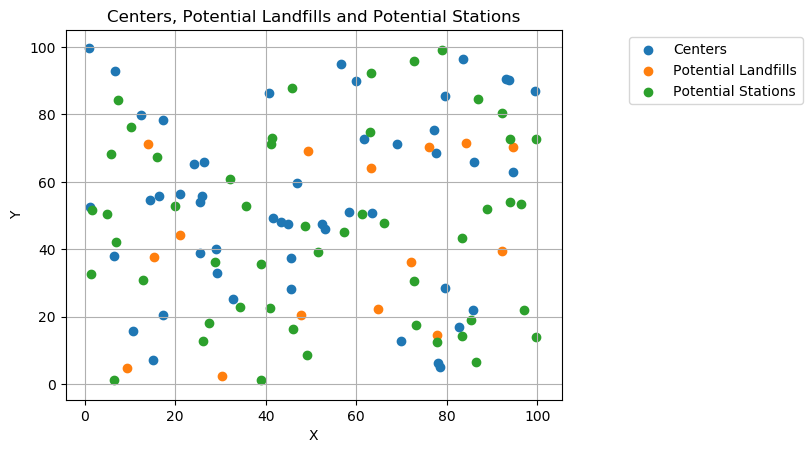

PyObject <matplotlib.legend.Legend object at 0x13dac6780>

In [279]:
scatter(centers[!,1],centers[!,2], label="Centers")
scatter(landfills[!,1],landfills[!,2], label="Potential Landfills")
scatter(stations[!,1],stations[!,2], label="Potential Stations")
PyPlot.title("Centers, Potential Landfills and Potential Stations")
xlabel("X")
ylabel("Y")
grid("on")
PyPlot.legend(bbox_to_anchor=(1.5,1))

In [280]:
e = calculateDistance(centers, stations);
f = calculateDistance(stations, landfills);

In [302]:
function buildLandfillsAndStations(d, e, f, q, a) 
    M = 1000000
    m,n = size(d)
    p = size(e, 2)
    model = Model(solver = GurobiSolver(MIPGap=0.0001, OutputFlag=0))

    @variable(model, x[1:m,1:n] >= 0)
    @variable(model, y[1:m,1:p] >= 0)
    @variable(model, v[1:p,1:n] >= 0)

    @variable(model, z[1:n] >= 0, Bin)
    @variable(model, w[1:p] >= 0, Bin)

    @objective(model, Min, 1 * sum(d[i,j] * x[i,j] for i in 1:m, j in 1:n) +
                           1 * sum(e[i,k] * y[i,k] for i in 1:m, k in 1:p) + 
                           0.5 * sum(f[k,j] * v[k,j] for k in 1:p, j in 1:n) + 
                           10000 * sum(w[k] for k in 1:p));

    @constraint(model, [i=1:m], 
                sum(x[i,j] for j=1:n) + 
                sum(y[i,k] for k in 1:p)  == q[i]) 
    @constraint(model, [k=1:p], sum(y[i,k] for i=1:m) == sum(v[k,j] for j=1:n) )
    @constraint(model, [i=1:m, j=1:n], x[i,j] <= M * z[j]) 
    @constraint(model, [k=1:p, j=1:n], v[k,j] <= M * z[j]) 
    @constraint(model, [i=1:m, k=1:p], y[i,k] <= M * w[k]) 
    @constraint(model, sum(z[j] for j=1:n) <= a) 
    @constraint(model, [k=1:p], sum(y[i,k] for i=1:m) <= 2000) 

    status = solve(model)

    x_solved = getvalue(x)
    y_solved = getvalue(y)
    v_solved = getvalue(v)
    z_solved = getvalue(z)
    w_solved = getvalue(w)
    distance = getobjectivevalue(model)

    return distance, x_solved, y_solved, v_solved, z_solved, w_solved 
end

buildLandfillsAndStations (generic function with 1 method)

In [309]:
totalcostA, xA, yA, vA, zA, wA = buildLandfillsAndStations(d, e, f, q, 5);

Academic license - for non-commercial use only


In [304]:
l = convert(Matrix,landfills)
s = convert(Matrix,stations)
built_lA = l .* zA;
built_lA_indeces = findall(x -> x>=1,built_lA[:,1])
built_sA = s .* wA;
built_sA_indeces = findall(x -> x>=1,built_sA[:,1]);

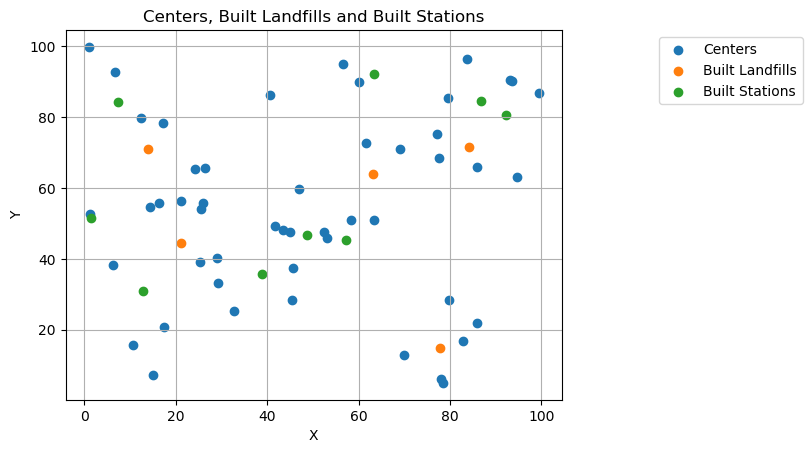

PyObject <matplotlib.legend.Legend object at 0x13e546d30>

In [325]:
scatter(centers[!,1],centers[!,2], label="Centers")
scatter(built_lA[built_lA_indeces,1],built_lA[built_lA_indeces,2], label="Built Landfills")
scatter(built_sA[built_sA_indeces,1],built_sA[built_sA_indeces,2], label="Built Stations")
PyPlot.title("Centers, Built Landfills and Built Stations")
xlabel("X")
ylabel("Y")
grid("on")
PyPlot.legend(bbox_to_anchor=(1.5,1))

In [291]:
built_s_indeces

9-element Array{Int64,1}:
  4
 12
 21
 23
 30
 31
 32
 39
 45

We build 9 stations

In [308]:
sum(v)/(sum(y)+sum(x))

0.2598927187121266

35% of waste get compacted.

Total transportation cost is calculated as the objective value minus the daily cost of operating the transfer stations:

In [317]:
println("Current transport cost: ", totalcostA - 10000 * sum(wA))
println("Previous transport cost: ", distance)
println("Difference in transport cost: ", distance - (totalcostA - 10000 * sum(wA)))

Current transport cost: 718642.7541913855
Previous transport cost: 840487.5240012797
Difference in transport cost: 121844.76980989426


The total daily cost is the objective value of the model

In [318]:
println("Current total daily cost: ", totalcostA)
println("Previous total daily  cost: ", distance)
println("Difference in total daily  cost: ", distance - totalcostA )

Current total daily cost: 808642.7541913855
Previous total daily  cost: 840487.5240012797
Difference in total daily  cost: 31844.769809894264


Total distance travlelled:

In [356]:
sum(d[i,j]*xA[i,j] for i = 1:50, j=1:15) +
sum(e[i,k]*yA[i,k] for i = 1:50, k=1:50) + sum(f[k,j]*vA[k,j] for k=1:50, j = 1:15)

876496.7565920667

# Second region

## Julia Implementation of previous model

In [319]:
d2 = calculateDistance(centers2, landfills2);
q2 = convert(Matrix,quantity2);
e2 = calculateDistance(centers2, stations2);
f2 = calculateDistance(stations2, landfills2);

In [320]:
totalcostB, xB, yB, vB, zB, wB = buildLandfillsAndStations(d2, e2, f2, q2, 5);

Academic license - for non-commercial use only


In [323]:
l2 = convert(Matrix,landfills2)
s2 = convert(Matrix,stations2)
built_lB = l2 .* zB;
built_lB_indeces = findall(x -> x>=1,built_lB[:,1])
built_sB = s2 .* wB;
built_sB_indeces = findall(x -> x>=1,built_sB[:,1]);

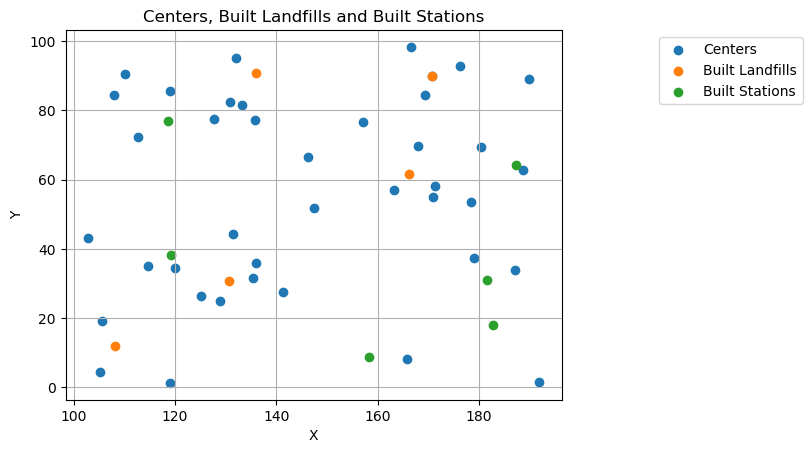

PyObject <matplotlib.legend.Legend object at 0x13f596128>

In [331]:
scatter(centers2[!,1],centers2[!,2], label="Centers")
scatter(built_lB[built_lB_indeces,1],built_lB[built_lB_indeces,2], label="Built Landfills")
scatter(built_sB[built_sB_indeces,1],built_sB[built_sB_indeces,2], label="Built Stations")
PyPlot.title("Centers, Built Landfills and Built Stations")
xlabel("X")
ylabel("Y")
grid("on")
PyPlot.legend(bbox_to_anchor=(1.5,1))

Total daily cost is 1,151,761 dollars.

In [327]:
totalcostB

1.1517612304605765e6

## Both regions

In [336]:
all_centers = vcat(centers, centers2)
all_landfills = vcat(landfills, landfills2)
all_stations = vcat(stations, stations2)
all_quantity = vcat(quantity, quantity2)
d3 = calculateDistance(all_centers, all_landfills);
q3 = convert(Matrix,all_quantity);
e3 = calculateDistance(all_centers, all_stations);
f3 = calculateDistance(all_stations, all_landfills);

In [337]:
totalcostC, xC, yC, vC, zC, wC = buildLandfillsAndStations(d3, e3, f3, q3, 10);

Academic license - for non-commercial use only


In [339]:
l3 = convert(Matrix,all_landfills)
s3 = convert(Matrix,all_stations)
built_lC = l3 .* zC;
built_lC_indeces = findall(x -> x>=1,built_lC[:,1])
built_sC = s3 .* wC;
built_sC_indeces = findall(x -> x>=1,built_sC[:,1]);

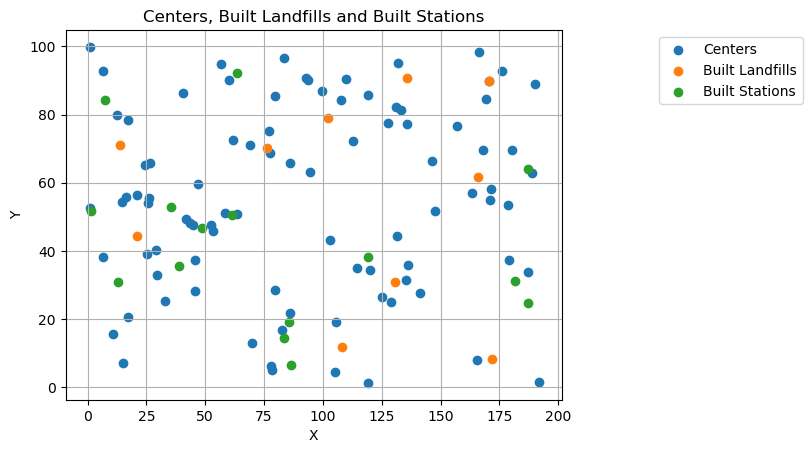

PyObject <matplotlib.legend.Legend object at 0x13e233358>

In [350]:
scatter(all_centers[!,1],all_centers[!,2], label="Centers")
scatter(built_lC[built_lC_indeces,1],built_lC[built_lC_indeces,2], label="Built Landfills")
scatter(built_sC[built_sC_indeces,1],built_sC[built_sC_indeces,2], label="Built Stations")
PyPlot.title("Centers, Built Landfills and Built Stations")
xlabel("X")
ylabel("Y")
grid("on")
PyPlot.legend(bbox_to_anchor=(1.5,1))

Total daily cost is 1,865,384 dollars

In [343]:
totalcostC

1.8653845034414865e6

In [346]:
(totalcostA + totalcostB) - totalcostC

95019.48121047532

In [348]:
totalcostA + totalcostB

1.9604039846519618e6

# Memo

Optimizing the 2 regions together brings important benefits, the total daily cost is $95,000 lower than if we build the landfills and stations separately in the two regions. In total we build 10 landfills, but if we consider each region separately we spend 1,960,403 dollars. The cost savings arise from the fact that we could place more than 5 landfills in one of the regions.

By visually inspecting the plot above, we note that 3 of the landfills are in Region A (from 0 to 100 on x axis) and the rest of 7 are in region B. So the solution violates the desired number of 5 landfills per region for region B, and environmental concerns could arise. The reason we are limiting the number of landfills was to protect the envinronment, and this solution seems to be affecting region B more. 

On the other hand, from the 15 total transfer stations, 11 of them are in region A and 4 in region B (also from the plot). This may have budget implications since the cost to run a station every day is 10,000 dollars. The 2 regions should come to an agreement in terms of budget. Perhaps the solution is good since region B is at disadvantage from an environmental perspective and region A from a cost perspective.

In any case there are many factors to consider when implemeting the results of an optimization model. Getting the support of the decision makers is crucial in ensuring the success of the project. 

